## Задача 1.2
**Выборка**: [Ирисы Фишера](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_iris.html).

Задана выборка описаний 150 экземпляров ириса разных видов. Описание каждого ириса состоит из четырех признаков:
* Длина наружной доли околоцветника (англ. sepal length);
* Ширина наружной доли околоцветника (англ. sepal width);
* Длина внутренней доли околоцветника (англ. petal length);
* Ширина внутренней доли околоцветника (англ. petal width).

Требуется определить насколько в среднем различается каждая из этих характеристик между разными видами.

Для каждой из данных характеристик выбрать подходящий размер эффекта из https://en.wikipedia.org/wiki/Effect_size#Types.

Посчитать соответствующее значение.

In [1]:
import scipy.stats as st
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.random import randn, seed
seed(1)
# prepare data
text_size = 14
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['lines.markersize'] = 6
plt.rcParams['xtick.labelsize'] = text_size
plt.rcParams['ytick.labelsize'] = text_size
plt.rcParams['legend.fontsize'] = text_size
plt.rcParams['axes.titlesize'] = text_size
plt.rcParams['axes.labelsize'] = text_size
plt.rcParams['figure.figsize'] = (16.0, 8.0)
plt.rcParams['font.size'] = text_size

In [2]:
from sklearn.datasets import load_iris
data = load_iris()

In [3]:
df = pd.DataFrame(data= np.c_[data['data'], data['target']],
                     columns= data['feature_names'] + ['target'])
df['species'] = data['target_names'][data['target']]
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target,species
0,5.1,3.5,1.4,0.2,0.0,setosa
1,4.9,3.0,1.4,0.2,0.0,setosa
2,4.7,3.2,1.3,0.2,0.0,setosa
3,4.6,3.1,1.5,0.2,0.0,setosa
4,5.0,3.6,1.4,0.2,0.0,setosa


 Бокслплоты:

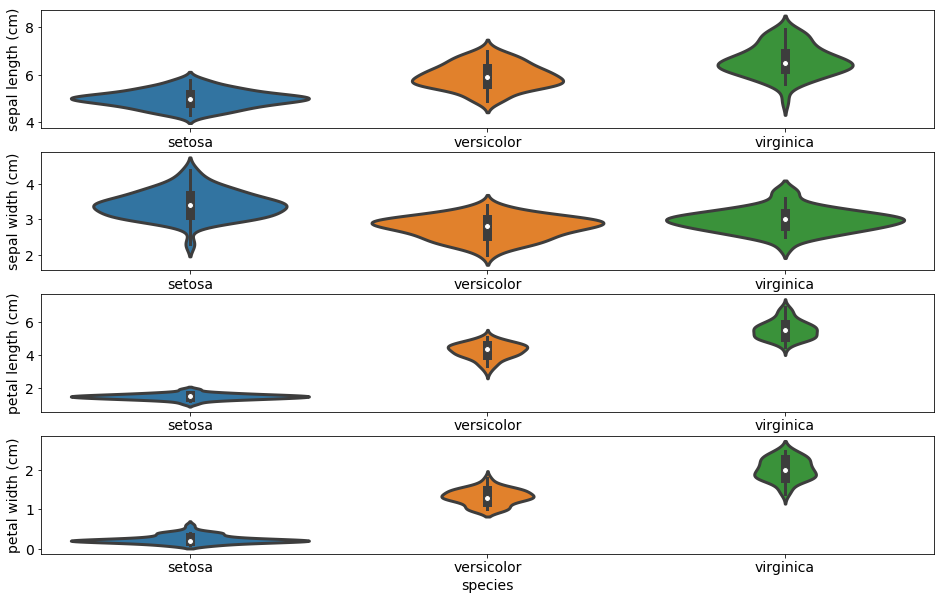

In [4]:
plt.figure(figsize=(16, 10))
plt.subplot(4, 1, 1)
sns.violinplot(x='species',y='sepal length (cm)',data=df)
plt.subplot(4, 1, 2)
sns.violinplot(x='species',y='sepal width (cm)',data=df)
plt.subplot(4, 1, 3)
sns.violinplot(x='species',y='petal length (cm)',data=df)
plt.subplot(4, 1, 4)
sns.violinplot(x='species',y='petal width (cm)',data=df)
plt.show()

Проверим нормальность данных с помощью критерия Шапиро-Уилка. Если данные нормальные, доверительный интервал строим с помощью критерия Стьюдента. Если нет, то с помощью бутстрепа.

In [5]:
for f in df.columns[:4]:
    for type_ in ['setosa', 'versicolor', 'virginica']:
        sample = df[df['species'] == type_][f].values
        print(f'вид {type_}, признак {f}, p-value {st.shapiro(sample)[1]}')


вид setosa, признак sepal length (cm), p-value 0.4595281183719635
вид versicolor, признак sepal length (cm), p-value 0.46473264694213867
вид virginica, признак sepal length (cm), p-value 0.25832483172416687
вид setosa, признак sepal width (cm), p-value 0.20465604960918427
вид versicolor, признак sepal width (cm), p-value 0.33798879384994507
вид virginica, признак sepal width (cm), p-value 0.1809043288230896
вид setosa, признак petal length (cm), p-value 0.05464918911457062
вид versicolor, признак petal length (cm), p-value 0.1584833413362503
вид virginica, признак petal length (cm), p-value 0.10977369546890259
вид setosa, признак petal width (cm), p-value 1.8525804534874624e-06
вид versicolor, признак petal width (cm), p-value 0.027278218418359756
вид virginica, признак petal width (cm), p-value 0.08695744723081589


Видно, что признак petal width (cm) сильно отклоняется от нормального распределения.


Берем как метрику для эффекта корреляцию Пирсона.
Считаем размер эффекта и строим доверительный интервал

In [6]:
def get_effect_size(x):
    if x <= 0.1:
        return 'small'
    elif x <= 0.3:
        return 'medium'
    elif x <= 0.5:
        return 'large'
    else:
        return 'very large'
from scipy.stats import pearsonr

In [7]:
import statsmodels.stats.api as sms
from arch.bootstrap import IndependentSamplesBootstrap

for pair in [('setosa', 'versicolor'),
            ('setosa', 'virginica'),
            ('versicolor', 'virginica')]:
    print(pair)
    print()
    for f in df.columns[:4]:
        x = df[df['species'] == pair[0]][f].values
        y = df[df['species'] == pair[1]][f].values
        eff = pearsonr(x, y)[0]
        if f != 'petal width (cm)':
            cm = sms.CompareMeans(sms.DescrStatsW(x), sms.DescrStatsW(y))
            interval = cm.tconfint_diff(usevar='unequal')

            print(f'признак: {f}, \nкорреляция Пирсона:{np.round(eff,3)}: {get_effect_size(np.abs(eff))} ')
            print(f'доверительный интервал {[np.round(i,3) for i in interval]}')
            print()
        else:
            bs = IndependentSamplesBootstrap(x, y)
            interval = bs.conf_int(lambda x1, x2 : np.mean(x1) - np.mean(x2), 1000)
            print(f'признак: {f}, \nкорреляция Пирсона:{np.round(eff,3)}: {get_effect_size(np.abs(eff))} ')
            print(f'доверительный интервал {[np.round(i,3)[0] for i in interval]}')
            print()

('setosa', 'versicolor')

признак: sepal length (cm), 
корреляция Пирсона:-0.081: small 
доверительный интервал [-1.106, -0.754]

признак: sepal width (cm), 
корреляция Пирсона:-0.103: medium 
доверительный интервал [0.509, 0.787]

признак: petal length (cm), 
корреляция Пирсона:-0.188: medium 
доверительный интервал [-2.938, -2.654]

признак: petal width (cm), 
корреляция Пирсона:-0.19: medium 
доверительный интервал [-1.148, -1.028]

('setosa', 'virginica')

признак: sepal length (cm), 
корреляция Пирсона:0.134: medium 
доверительный интервал [-1.787, -1.377]

признак: sepal width (cm), 
корреляция Пирсона:-0.004: small 
доверительный интервал [0.304, 0.584]

признак: petal length (cm), 
корреляция Пирсона:0.101: medium 
доверительный интервал [-4.252, -3.924]

признак: petal width (cm), 
корреляция Пирсона:0.12: medium 
доверительный интервал [-1.87, -1.706]

('versicolor', 'virginica')

признак: sepal length (cm), 
корреляция Пирсона:-0.142: medium 
доверительный интервал [-0.882, 

# Вывод
Судя по доверительным интервалам, в зависимости от вида ирисов значения признаков хорошо различаются.